In [1]:
import kornia as K
from kornia.contrib import FaceDetector, FaceDetectorResult, FaceKeypoint

In [2]:
import os
import numpy as np
import cv2
import decord as de
import torch
from matplotlib import pyplot as plt

DEVICE = 'cuda:0'
FOLDER = 'data'
ctx = de.cpu(0)

In [3]:
def get_frames(path):
    vr = de.VideoReader(path, height=320, width=180)
    return vr[:].asnumpy()

In [4]:
def draw_keypoint(img: np.ndarray, det: FaceDetectorResult, kpt_type: FaceKeypoint) -> np.ndarray:
    kpt = det.get_keypoint(kpt_type).int().tolist()
    return cv2.circle(img, kpt, 2, (255, 0, 0), 2)

def visualize(frame, vis_threshold = 0.7):
    img_vis = frame.copy()
    vis_keypoints = True
    img_tensor = torch.tensor(frame).permute(2, 0, 1).unsqueeze(0).float().to(DEVICE)
    with torch.no_grad():
        xdets = face_detection(img_tensor)
    xdets = [FaceDetectorResult(o) for o in xdets]
    for b in xdets:
        if b.score < vis_threshold:
            continue

        # draw face bounding box
        img_vis = cv2.rectangle(
            img_vis, b.top_left.int().tolist(), b.bottom_right.int().tolist(), (0, 255, 0), 4)

        if vis_keypoints:
            # draw facial keypoints
            img_vis = draw_keypoint(img_vis, b, FaceKeypoint.EYE_LEFT)
            img_vis = draw_keypoint(img_vis, b, FaceKeypoint.EYE_RIGHT)
            img_vis = draw_keypoint(img_vis, b, FaceKeypoint.NOSE)
            img_vis = draw_keypoint(img_vis, b, FaceKeypoint.MOUTH_LEFT)
            img_vis = draw_keypoint(img_vis, b, FaceKeypoint.MOUTH_RIGHT)

            # draw the text score
            cx = int(b.xmin)
            cy = int(b.ymin + 12)
            img_vis = cv2.putText(img_vis, f"{b.score:.2f}", (cx, cy), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))

    plt.imshow(img_vis)
    plt.show()

In [117]:
video_path = os.path.join(FOLDER, sorted(os.listdir(FOLDER))[2])
frames = get_frames(video_path)[:427]
frames.shape

(427, 320, 180, 3)

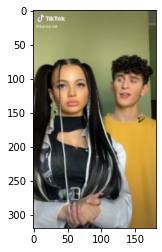

In [118]:
plt.imshow(frames[0])
plt.show()

In [119]:
face_detection = FaceDetector().float().to(DEVICE)

In [120]:
img_tensor = torch.tensor(frames[0:1]).permute(0, 3, 1, 2).float().to(DEVICE)

In [121]:
# %%timeit -n 10 -r 2
with torch.no_grad():
    dets = face_detection(img_tensor)

In [122]:
dets = [FaceDetectorResult(o) for o in dets]

In [123]:
visualize(frames[0])

In [124]:
import torchvision.transforms as T

In [125]:
def make_hash(frame):
    grayscaled_image = K.color.rgb_to_grayscale(torch.tensor(frame).permute(2, 0, 1).float())
    kW, kH = grayscaled_image.shape[2] // 8, grayscaled_image.shape[1] // 8
    resized_image = torch.nn.functional.avg_pool2d(grayscaled_image, kernel_size=(kH, kW), stride=(kH, kW))
    return resized_image.byte()

In [126]:
def get_scene_changes(frames, threshold=10):
    hashes = [make_hash(frame) for frame in frames]
    hash_diff = torch.tensor([torch.mean(torch.abs(hashes[i+1].float() - hashes[i])) for i in range(len(hashes) - 1)]).int()
    hash_diffdiff = torch.tensor([(hash_diff[i+1])/(hash_diff[i] if hash_diff[i] != 0 else 1) for i in range(len(hash_diff) - 1)]).int()
    scene_change_indexes = [hash_diffdiff > threshold][0].int().nonzero() + 2
    return [0] + scene_change_indexes.flatten().tolist()

In [127]:
scene_change_indexes = get_scene_changes(frames)
scene_change_indexes

[0, 129, 179, 239]

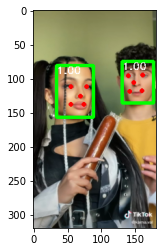

In [128]:
visualize(frames[scene_change_indexes[-1]])

In [129]:
def get_all_bboxes(frame, score=0.7):
    img_tensor = torch.tensor(frame).permute(2, 0, 1).unsqueeze(0).float().to(DEVICE)
    with torch.no_grad():
        dets = face_detection(img_tensor)
        dets = [FaceDetectorResult(o) for o in dets]
        dets = [d for d in dets if d.score > score]
    return dets

In [130]:
bboxes = [get_all_bboxes(frame) for frame in frames]
len_bboxes = np.array([len(b) for b in bboxes])

In [131]:
bbox_changes = np.array(len_bboxes)[:-1] != np.array(len_bboxes)[1:]

In [132]:
bbox_change_indexes = [bbox_changes.nonzero()[0] + 1]

In [135]:
scene_start_indexes = list(set(scene_change_indexes + bbox_change_indexes[0].tolist()))

In [136]:
scene_start_indexes

[0, 129, 420, 239, 179]

In [137]:
start_index, end_index = scene_start_indexes[0], scene_start_indexes[1] - 1

In [168]:
frame_0_bboxes = [b for b in bboxes[0]]
frame_1_bboxes = [b for b in bboxes[10]]

In [169]:
[(b.top_left.int().tolist(), b.bottom_right.int().tolist()) for b in frame_1_bboxes]

[([111, 86], [154, 141]), ([32, 85], [82, 152])]

In [170]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [180]:
b = frame_0_bboxes[0]
c = frame_1_bboxes[1]

In [183]:
b

In [181]:
bb = b.top_left.int().tolist() + b.bottom_right.int().tolist()
cc = c.top_left.int().tolist() + c.bottom_right.int().tolist()

In [182]:
bb_intersection_over_union(bb, cc)

0.9168035030103996

In [225]:
persons = {}
for i in range(start_index, end_index):
    if i == 0:
        persons = {i: [v.top_left.int().tolist() + v.bottom_right.int().tolist()]
                   for i, v in enumerate(bboxes[i])}
        continue
    
    frame_bboxes = [[v.top_left.int().tolist() + v.bottom_right.int().tolist()] for v in bboxes[i]]
    for person in persons.values():
        last_frame_bboxes = person[-1]
        for fr_bb in frame_bboxes:
            #print('last_frame_bboxes', last_frame_bboxes)
            # print('fr_bb[0]', fr_bb[0])
            if bb_intersection_over_union(last_frame_bboxes, fr_bb[0]) > 0.5:
                person.append(fr_bb[0])
                break
        #print(person)

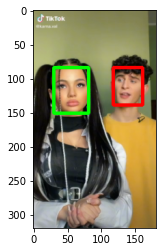

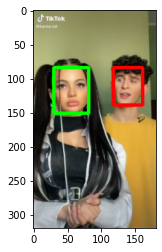

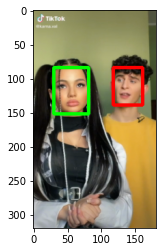

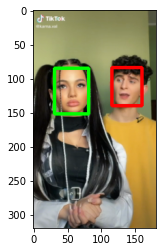

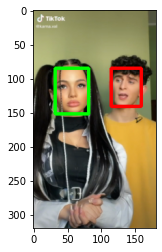

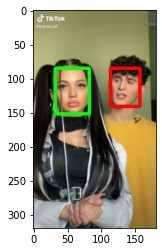

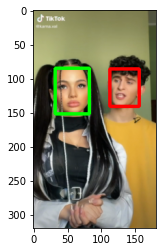

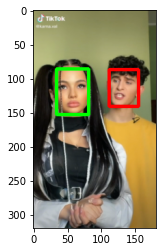

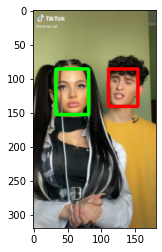

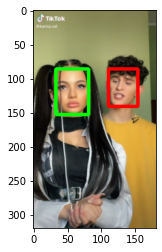

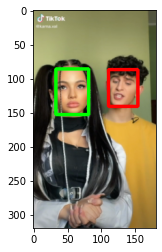

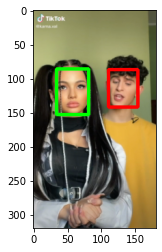

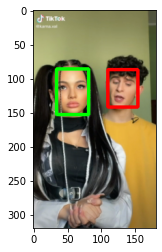

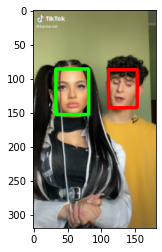

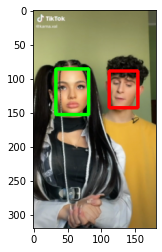

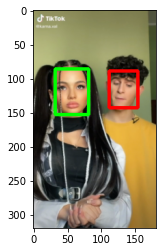

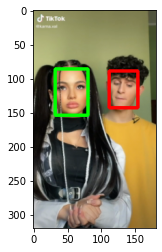

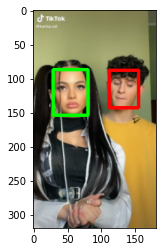

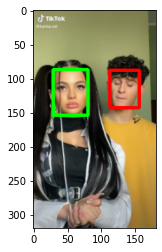

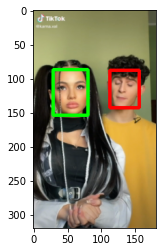

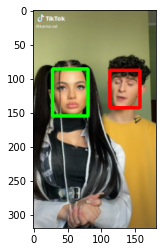

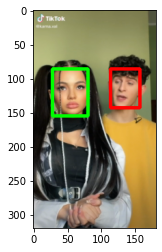

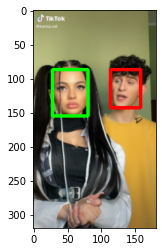

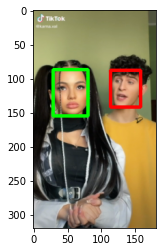

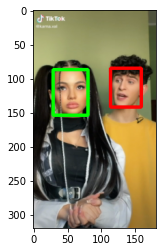

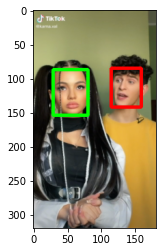

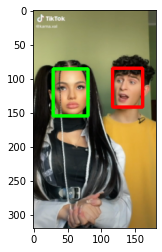

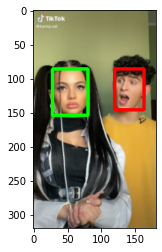

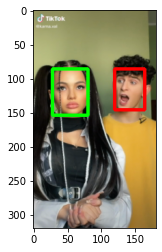

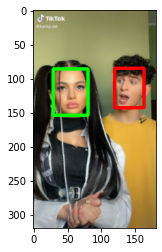

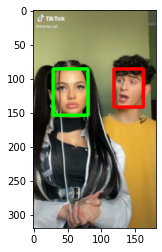

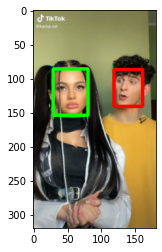

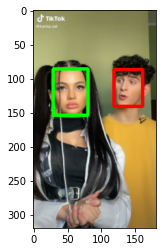

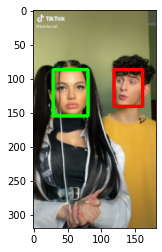

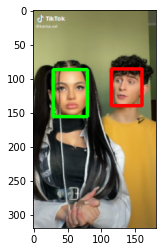

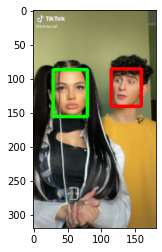

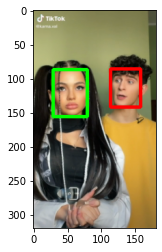

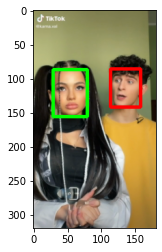

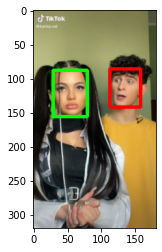

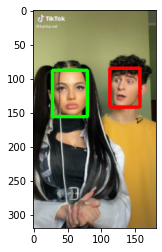

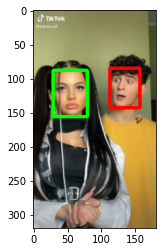

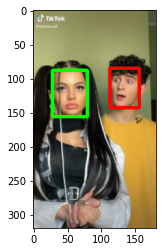

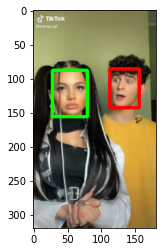

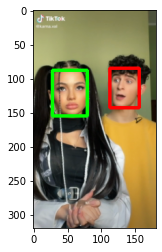

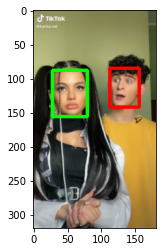

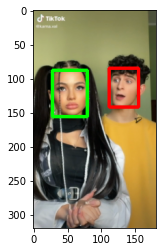

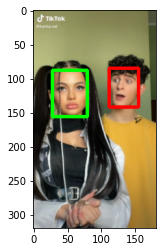

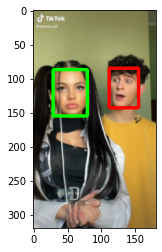

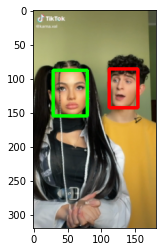

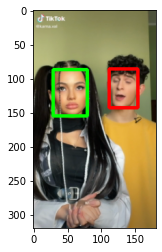

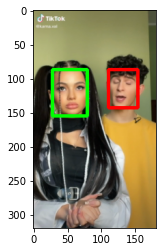

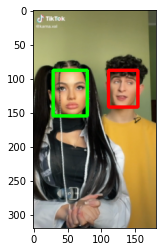

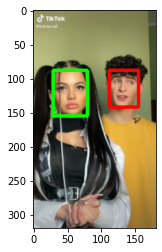

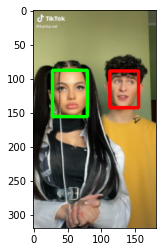

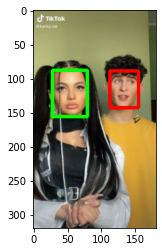

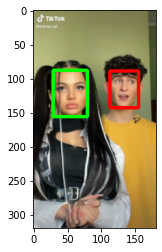

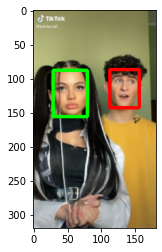

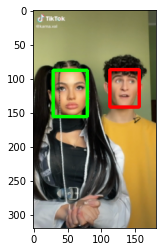

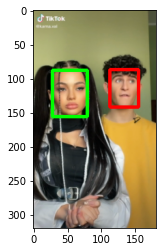

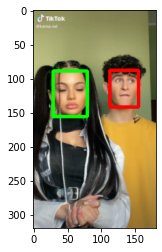

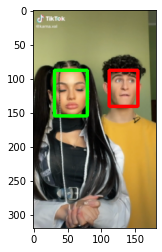

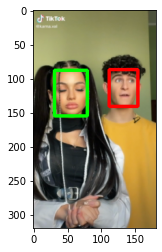

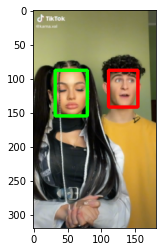

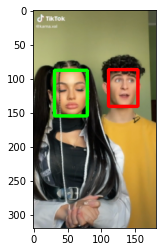

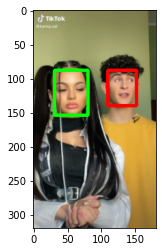

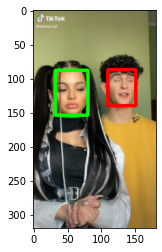

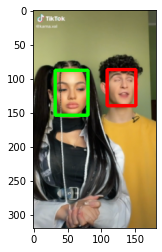

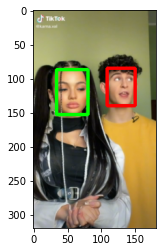

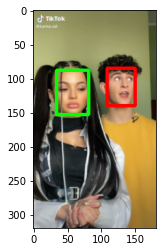

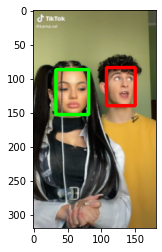

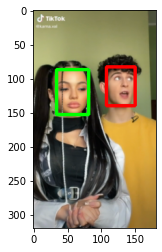

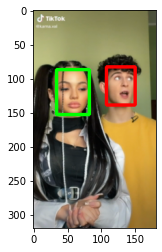

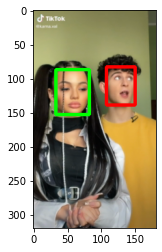

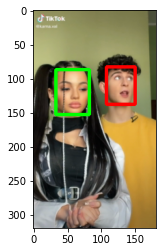

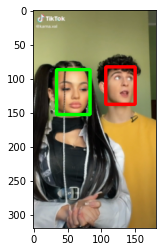

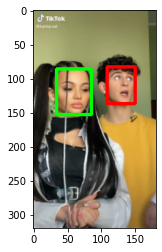

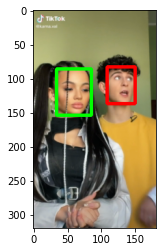

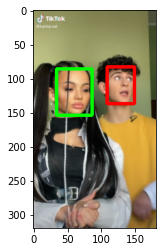

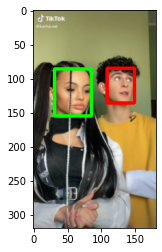

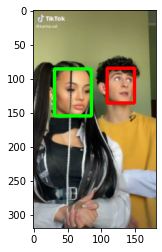

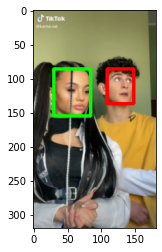

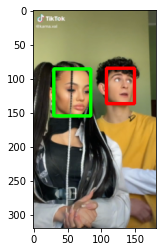

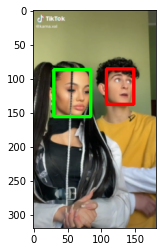

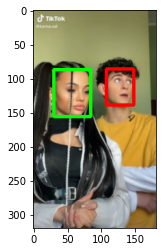

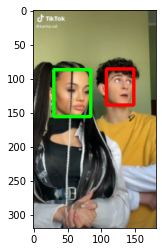

In [238]:
import time
for index, frame in enumerate(frames[start_index:end_index]):
    person_0 = persons[0][index]
    person_1 = persons[1][index]
    img_vis = frame.copy()
    img_vis = cv2.rectangle(img_vis, person_0[:2], person_0[2:], (0, 255, 0), 4)
    img_vis = cv2.rectangle(img_vis, person_1[:2], person_1[2:], (255, 0, 0), 4)
    plt.imshow(img_vis)
    plt.show()